In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as sps
import scipy.integrate as si
import scipy.optimize as spo
import matplotlib.pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jnpl

<h3>TDSE Forward Problem</h3>

In [2]:
# size of spatial domain
L = 10.0

# set number of real space grid points for plotting
nx = 1025
# spatial grid for the purposes of plotting
xvec = np.linspace(-L, L, nx)

# the basis functions used in our Fourier representation
# will be from n = -nF to n = nF
nF = 32
# matrix for converting Fourier basis coefficients to real space values
Fnvec = np.arange(-nF, nF + 1) # Fnvec=-nfb,...,0,...,nfb
Fcnvrtmat = np.exp(1j * np.pi * np.outer(Fnvec, xvec) / L) / np.sqrt(2 * L)

---
**Potential Function**

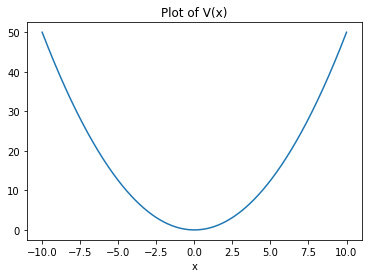

In [3]:
# define potential for generating training data

def v(x):
    # dimensionless quantum harmonic oscillator potential
    return 0.5 * x**2
    # rescaled symmetric double well potential
    # return 0.0025*(x**2 - 25)**2
    # scaled asymmetric double well potential
    # return 0.0003*((x-3)**4 + 10*(x-5)**3)
    # soft coulomb potential
    # return -1 / np.sqrt(x**2 + 0.25)

# compute true potential for plotting
vxvec = v(xvec)

# plot true potential
plt.plot(xvec, vxvec)
plt.title('Plot of V(x)')
plt.xlabel('x')
plt.show()

In [80]:
# transform potential function to Fourier representation
# using quadrature method
# (in tdse-adj-cheb-fft-vs-quad-kbc.ipynb we show that the
# using a quadrature method produces much more accurate results)
Fvtoeprow = []
for thisn in range(2 * nF +1):
    def intgrnd(x):
        return v(x) * np.exp(-1j * np.pi * thisn * x / L) / (2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    Fvtoeprow.append(si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0])
Fvtoeprow = np.array(Fvtoeprow)
Fvmat = sl.toeplitz(r=Fvtoeprow, c=Fvtoeprow.conj())

print(Fvmat.shape)

(65, 65)


---
**Eigendecomposition of a Fourier Represented Potential**

In [6]:
# construct the kinetic matrix representation of the
# kinetic operator in the Fourier basis
# (this is constant for a given system)
kmat = np.diag(np.arange(-nF, nF + 1)**2 * np.pi**2 / (2 * L**2))

# construct the Hamiltonian matrix representation of the
# Hamiltonian operator in the Fourier basis
Fhmat = kmat + Fvmat

# check if the Hamiltonian matrix is Hermitian
print('hmat Hermitian check (should be close to zero):', nl.norm(Fhmat - Fhmat.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
Fspc, Fstts = nl.eigh(Fhmat)

# check if the eigendecomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(Fhmat @ Fstts - Fstts @ np.diag(Fspc)), sep='\n')

# check if the eigenstates are unitary
print('Unitary stts check (should be close to zero):', nl.norm(Fstts @ Fstts.T.conj() - np.eye(2 * nF + 1)), sep='\n')

hmat Hermitian check (should be close to zero):
0.0
Check if hmat is diagonalized (should be close to zero):
3.392077258042753e-13
Unitary stts check (should be close to zero):
1.2469110651416776e-14


[0.5 1.5 2.5 3.5 4.5 5.5]


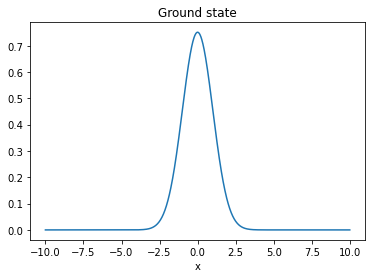

Quick check of normalization (should be close to 1):
0.9999999999999993
Check of normalization (should be close to 1):
0.9999999999999993


In [7]:
# find indices that sort eigenvalues
ordering = np.argsort(Fspc)

# print the first few eigenvalues
print(Fspc[ordering[:6]])

# pick out and plot ground state
groundstate = ordering[0]
wavefn = Fstts[:,groundstate] @ Fcnvrtmat
plt.plot(xvec, np.real(wavefn))
plt.title('Ground state')
plt.xlabel('x')
plt.show()

# quick and dirty check of normalization
print('Quick check of normalization (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Check of normalization (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

---
<h3>Foward Propagation</h3>

In [72]:
# solve the forward problem in the Fourier
# representation and store the trajectory
# in Famat

# set the size of a time step
dt = 1e-2

# set the number of time steps to take starting from
# the initial state (a single trajectory should be
# nts + 1 states, this includes the initial state)
ntsteps = 600  # 400  # 200  # 100


---
**Initial Wave Function and its Fourier Representation**

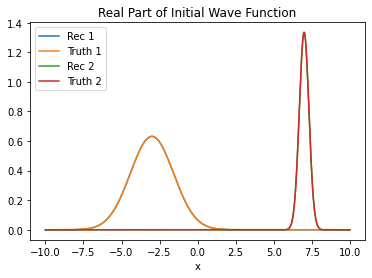

L2 Error psi0_1: 4.072507283500472e-06
L-infinity Error psi0_1: 1.8301527573114097e-06
L2 Error psi0_2: 0.0158160305579353
L-infinity Error psi0_2: 0.0016468761418351185


In [73]:
# define initial state(s) and transform to Fourier basis

ainitvec = []

def psi0_1(x):
    # return 1.0 + np.tanh((1 - x**2)/0.5)  # rounded box function
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])  # triangular pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])  # parabolic pulse
    # return (np.cosh(x))**(-2)  # hyperbolic secant squared
    # return np.exp(-np.abs(x))  # Laplace
    # HSB's "super simple initial condition"
    # return np.exp(-x**2) * (2.0 / np.pi)**0.25  # Gaussian with L^2 norm = 1
    return np.exp(-(x + 3)**2 / 4) * (2.0 / np.pi)**0.25

# WHEN USING HSB'S GAUSSIAN WITH L^2 NORM = 1
# normpsi0_1_fn = psi0_1
# WHEN NOT USING HSB'S GAUSSIAN WITH L^2 NORM = 1
# compute psi0 normalization term
psi0_1_probintgrnd = lambda x: np.abs(psi0_1(x))**2
psi0_1_normtrm = np.sqrt(si.quad(psi0_1_probintgrnd, -L, L)[0])
# define normalized psi function to be used by
# a scipy.integrate methods
def normpsi0_1_fn(x):
    return psi0_1(x)/psi0_1_normtrm

# compute the Fourier basis representation of the
# normalized psi0 function using quadrature method
normpsi0_1_quad = np.zeros(nF + 1, dtype=np.complex128)
for thisn in range (nF + 1):
    def intgrnd(x):
        return normpsi0_1_fn(x) * np.exp(-1j * np.pi * thisn * x / L) / np.sqrt(2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    normpsi0_1_quad[thisn] = si.quad(rintgrnd, -L, L)[0] + 1j*si.quad(iintgrnd, -L, L)[0]

ainit_1 = np.concatenate([np.conjugate(np.flipud(normpsi0_1_quad[1:])), normpsi0_1_quad])

ainitvec.append(ainit_1)

def psi0_2(x):
    # return 1.0 + np.tanh((1 - x**2)/0.5)  # rounded box function
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])  # triangular pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])  # parabolic pulse
    # return (np.cosh(x))**(-2)  # hyperbolic secant squared
    # return np.exp(-np.abs(x))  # Laplace
    # HSB's "super simple initial condition"
    # return np.exp(-x**2) * (2.0 / np.pi)**0.25  # Gaussian with L^2 norm = 1
    return np.exp(-(x - 7)**2 / 0.2) * (2.0 / np.pi)**0.25

# WHEN USING HSB'S GAUSSIAN WITH L^2 NORM = 1
# normpsi0_2_fn = psi0_2
# WHEN NOT USING HSB'S GAUSSIAN WITH L^2 NORM = 1
# compute psi0 normalization term
psi0_2_probintgrnd = lambda x: np.abs(psi0_2(x))**2
psi0_2_normtrm = np.sqrt(si.quad(psi0_2_probintgrnd, -L, L)[0])
# define normalized psi function to be used by
# a scipy.integrate methods
def normpsi0_2_fn(x):
    return psi0_2(x)/psi0_2_normtrm

# compute the Fourier basis representation of the
# normalized psi0 function using quadrature method
normpsi0_2_quad = np.zeros(nF + 1, dtype=np.complex128)
for thisn in range (nF + 1):
    def intgrnd(x):
        return normpsi0_2_fn(x) * np.exp(-1j * np.pi * thisn * x / L) / np.sqrt(2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    normpsi0_2_quad[thisn] = si.quad(rintgrnd, -L, L)[0] + 1j*si.quad(iintgrnd, -L, L)[0]

ainit_2 = np.concatenate([np.conjugate(np.flipud(normpsi0_2_quad[1:])), normpsi0_2_quad])

ainitvec.append(ainit_2)

normpsi0_1_vecrec = ainitvec[0] @ Fcnvrtmat
normpsi0_1_vec = normpsi0_1_fn(xvec)

normpsi0_2_vecrec = ainitvec[1] @ Fcnvrtmat
normpsi0_2_vec = normpsi0_2_fn(xvec)

# plot the real part of the normalized psi0
plt.plot(xvec, normpsi0_1_vecrec.real, label="Rec 1")
plt.plot(xvec, normpsi0_1_vec.real, label="Truth 1")
plt.plot(xvec, normpsi0_2_vecrec.real, label="Rec 2")
plt.plot(xvec, normpsi0_2_vec.real, label="Truth 2")
plt.title('Real Part of Initial Wave Function')
plt.xlabel('x')
plt.legend()
plt.show()

print('L2 Error psi0_1:', nl.norm(normpsi0_1_vecrec - normpsi0_1_vec))
print('L-infinity Error psi0_1:', np.max(np.abs(normpsi0_1_vecrec - normpsi0_1_vec)))

print('L2 Error psi0_2:', nl.norm(normpsi0_2_vecrec - normpsi0_2_vec))
print('L-infinity Error psi0_2:', np.max(np.abs(normpsi0_2_vecrec - normpsi0_2_vec)))

---
**Forward Propagation of ainit using the Potential in Fourier Representation**

In [74]:
# compute the propagator matrix reusing the
# spectrum and states from the eigendecomposition
# of Hamiltonian matrix computed above
Fpropa = Fstts @ np.diag(np.exp(-1j * Fspc * dt)) @ Fstts.conj().T

Famatvec = []
# propagate the system starting from the initial "a" state
for thisainit in ainitvec:
    tempFamat = np.zeros((ntsteps + 1, 2 * nF + 1), dtype=np.complex128)
    tempFamat[0] = thisainit.copy()
    for i in range(ntsteps):
        tempFamat[i + 1] = Fpropa @ tempFamat[i]
    Famatvec.append(tempFamat)

# compute the wave function in space from each "a" vector
# do it all at once using matrix multiplication!
Fpsimat_1 = Famatvec[0] @ Fcnvrtmat
Fpsimat_2 = Famatvec[1] @ Fcnvrtmat

print('Done propagating.')

Done propagating.


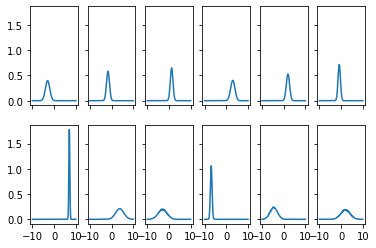

In [75]:
fig, axs = plt.subplots(nrows=2, ncols=6, sharex='all', sharey='all')

plottstep = ntsteps // 6

for i in range(2):
    for j in range(6):
        axs[i, j].plot(xvec, np.abs((Famatvec[i] @ Fcnvrtmat)[plottstep * j])**2)

plt.show()

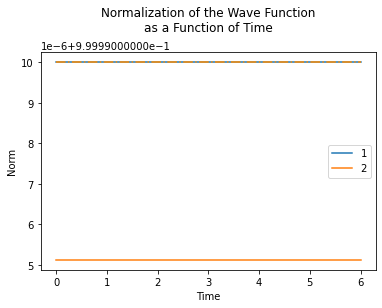

Average Norm of Trajectory Fpsimatnormvec_1 (should be close to 1):
0.9999999999996141
Average Norm of Trajectory Fpsimatnormvec_2 (should be close to 1):
0.9999951199332193


In [76]:
# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
Fpsimatnormvec_1 = si.trapezoid(np.abs(Fpsimat_1)**2, xvec, axis=1)
plt.plot(np.arange(ntsteps + 1) * dt, Fpsimatnormvec_1, label='1')
Fpsimatnormvec_2 = si.trapezoid(np.abs(Fpsimat_2)**2, xvec, axis=1)
plt.plot(np.arange(ntsteps + 1) * dt, Fpsimatnormvec_2, label='2')
plt.hlines(1 , 0, ntsteps * dt, linestyles='-.', colors='darkorange', label='_')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.legend()
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory Fpsimatnormvec_1 (should be close to 1):', Fpsimatnormvec_1.sum() / (ntsteps + 1), sep='\n')
print('Average Norm of Trajectory Fpsimatnormvec_2 (should be close to 1):', Fpsimatnormvec_2.sum() / (ntsteps + 1), sep='\n')

---
<h3>Chebyshev Representation</h3>

In [84]:
# set the number of Chebyshev coefficients
nc = 11

[ 2.50000000e+01  4.73695157e-15  2.50000000e+01  3.55271368e-15
 -9.47390314e-15  2.13162821e-14 -5.92118946e-15  1.42108547e-14
 -1.06581410e-14  1.65793305e-14 -3.43428989e-14  2.13162821e-14]


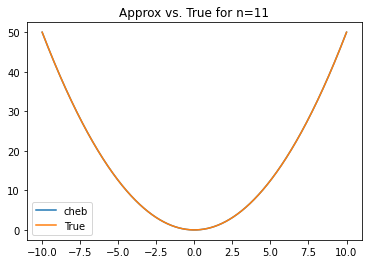

L2 Error (should be close to zero):
9.054280613274888e-13
L-infinity Error (should be close to zero):
1.5631940186722204e-13


In [87]:
# to test our Chebyshev representation let's represent
# the potential function, v(x), using Chebyshev polynomials
# then reconstruct it in real space and compare the sampled
# function to the reconstruction
# for the simple harmonic potential this should be
# exact because v(x) **is** a polynomial

def theta(k):
    return (k - 0.5) * np.pi / (nc + 1)

def g(k):
    # cos(\theta) ranges from [-1, 1] which is the domain
    # of the Chebyshev interpolation function so we need to
    # modify v()'s so when it is given x \in [-1, 1], it
    # actually spans the domain [-L, L]
    # to do that, we multiply by np.cos(theta(k)) by L
    return v(L * np.cos(theta(k)))

kvec = np.arange(1, nc + 2)
cnvec = np.arange(0, nc + 1)

cweights = np.ones(nc + 1)
cweights[0] = 0.5

# compute Chebyshev coefficients
cvec = 2 / (nc + 1) * np.sum(g(kvec) * np.cos(cnvec[..., np.newaxis] * theta(kvec)), axis=1)
cvec = cweights * cvec
print(cvec)

ctoxmat = sps.eval_chebyt(np.expand_dims(cnvec, 0), np.expand_dims(xvec / L, 1))
vrec = ctoxmat @ cvec

# plot reconstruction vs truth
plt.plot(xvec, vrec, label='cheb')
plt.plot(xvec, vxvec, label='True')
plt.title(f'Approx vs. True for n={nc}')
plt.legend()
plt.show()

# vec L2 error
print('L2 Error (should be close to zero):', nl.norm(v(xvec) - vrec), sep='\n')
# L-infinity error
print('L-infinity Error (should be close to zero):', np.max(np.abs(v(xvec) - vrec)), sep='\n')

---
**Form the Potential Matrix from the Chebyshev Representation**

In [89]:
# to test our Chebyshev representation let's construct
# the potential matrix, vmat, using Chebyshev polynomials
# via quadrature method then check the result against
# the potential matrix formed directly in the Fourier
# representation

# this function returns the chebyshev approximation of
# the potential at some spatial point x, this is needed
# for transforming the Chebyshev coefficients to the
# Fourier representation by quadrature method
# def vchebaprx(x):
    # don't forget the interval of the argument x is [-L, L]
    # but for the chebyshev representation it needs to be
    # [-1, 1] so we need to divide x by L
    # return sps.eval_chebyt(np.expand_dims(cnvec, 0), x / L) @ cvec

# compute the Fourier representation of the Chebyshev
# coefficients of the true potential
# cvrowquad = np.zeros(2 * nF + 1, dtype=np.complex128)
# for thisn in range(2 * nF + 1):
#     def intgrnd(x):
#         return vchebaprx(x) * np.exp(-1j * np.pi * thisn * x / L) / (2 * L)
#     def rintgrnd(x):
#         return intgrnd(x).real
#     def iintgrnd(x):
#         return intgrnd(x).imag
#     cvrowquad[thisn] = si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0]

# creates matrix that can be used to transform
# the Chebyshev coefficients to the Fourier representation
chebtoF = np.zeros((2 * nF + 1, nc + 1), dtype=np.complex128)
for thiscn in range(nc + 1):
    for thisn in range(2 * nF + 1):
        def intgrnd(x):
            tvec = lambda x: sps.eval_chebyt(np.expand_dims(thiscn, 0), x / L)
            return tvec(x) * np.exp(-1j * np.pi * thisn * x / L) / (2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag

        chebtoF[thisn, thiscn] = si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0]

# check how much the Fourier representation coefficients
# constructed from the Chebyshev representation differ from
# the true Fourier coefficients
# (i.e., compare the potential in the Fourier representation
# to the potential reconstructed from the Chebyshev representation)
print('L2 Norm Error (should be close to 0):', nl.norm(Fvtoeprow - chebtoF @ cvec))
print('L-infinity Error (should be close to 0):', np.max(np.abs(Fvtoeprow - chebtoF @ cvec)))

L2 Norm Error (should be close to 0): 2.610274033911567e-13
L-infinity Error (should be close to 0): 1.6643382799970866e-13


---
**Eigendecomposition of a Chebyshev Represented Potential**

In [82]:
# to test our Chebyshev representation let's compare
# the Hamiltonian matrix and its eigendecomposition
# constructed from the potential matrix reconstructed
# from the Chebyshev coefficients of the potential
# to the same features constructed directly in the
# Fourier representation

# make the potential matrix from the Chebyshev coefficents
cvmat = sl.toeplitz(r=chebtoF @ cvec, c=np.conj(chebtoF @ cvec))

# construct the Hamiltonian matrix representation of the
# Hamiltonian operator in the Fourier basis
chmat = kmat + cvmat

# check if the Hamiltonian matrix is Hermitian
print('hmat Hermitian check (should be close to zero):', nl.norm(chmat - chmat.T.conj()), sep='\n')

# eigendecomposition of the Hamiltonian matrix
cspc, cstts = nl.eigh(chmat)

# check if the eigendecomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(chmat @ cstts - cstts @ np.diag(cspc)), sep='\n')

# check if the eigenstates are unitary
print('Unitary stts check (should be close to zero):', nl.norm(cstts @ cstts.T.conj() - np.eye(2 * nF + 1)), sep='\n')

hmat Hermitian check (should be close to zero):
0.0
Check if hmat is diagonalized (should be close to zero):
3.3579866970635153e-13
Unitary stts check (should be close to zero):
1.1902270981501877e-14


In [ ]:
print('L2 Error of the Hamiltonian matrix (should be close to 0):', nl.norm(cvmat - Fvmat), sep='\n')
print('L2 Error of spectrum (should be close to 0):', nl.norm(cspc - Fspc), sep='\n')
print('L2 Error of states (should be close to 0):', nl.norm(cstts - Fstts), sep='\n')

# plt.plot(nl.norm(Fpsimat_1 - cpsimat_1, axis=1), '.')
# plt.title('L2 Error of cpsimat to Fpsimat\nfor Each Time Step')
# plt.show()

---
**Forward Propagation of ainit using the Potential in the Cheybshev Representation**

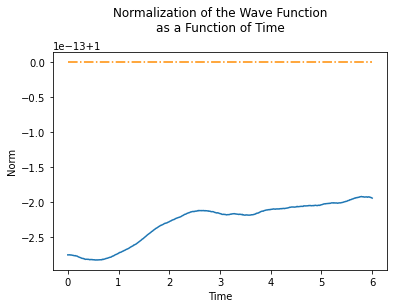

Average Norm of Trajectory (should be close to 1):
0.9999999999997723


In [83]:
# propagate the system using the Chebyshev
# representation of the true potential and compare
# if chebyshev propagation agrees with Fourier
# propagation

# compute the propagator matrix reusing the
# spectrum and states from the eigendecomposition
# of Hamiltonian matrix computed above
# cspc, cstts
cpropa = cstts @ np.diag(np.exp(-1j * cspc * dt)) @ cstts.conj().T

camatvec = []
# propagate the system starting from the initial "a" state
for thisainit in ainitvec:
    tempcamat = np.zeros((ntsteps + 1, 2 * nF + 1), dtype=np.complex128)
    tempcamat[0] = thisainit.copy()
    for i in range(ntsteps):
        tempcamat[i + 1] = cpropa @ tempcamat[i]
    camatvec.append(tempcamat)

# compute the wave function in space from each "a" vector
# do it all at once using matrix multiplication!
cpsimat_1 = camatvec[0] @ Fcnvrtmat
cpsimat_2 = camatvec[1] @ Fcnvrtmat

print('Done propagating.')

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=6, sharex='all', sharey='all')

plottstep = ntsteps // 6

for i in range(2):
    for j in range(6):
        axs[i, j].plot(xvec, np.abs((camatvec[i] @ Fcnvrtmat)[plottstep * j])**2)

plt.show()

print('L2 Error Trajectory 1 (should be close to 0):', nl.norm(cpsimat_1 - Fpsimat_1), sep='\n')
print('L2 Error Trajectory 2 (should be close to 0):', nl.norm(cpsimat_2 - Fpsimat_2), sep='\n')

In [ ]:
# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
cpsimatnormvec_1 = si.trapezoid(np.abs(cpsimat_1) ** 2, xvec, axis=1)
plt.plot(np.arange(ntsteps + 1) * dt, cpsimatnormvec_1, label='1')
cpsimatnormvec_2 = si.trapezoid(np.abs(cpsimat_2) ** 2, xvec, axis=1)
plt.plot(np.arange(ntsteps + 1) * dt, cpsimatnormvec_2, label='2')
plt.hlines(1 , 0, ntsteps * dt, linestyles='-.', colors='darkorange', label='_')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.legend()
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory 1 (should be close to 1):', cpsimatnormvec_1.sum() / (ntsteps + 1), sep='\n')
print('Average Norm of Trajectory 2 (should be close to 1):', cpsimatnormvec_2.sum() / (ntsteps + 1), sep='\n')

---
<h3>Inverse Problem - Adjoint Method</h3>

In [18]:
# form the entries of vmat from the Chebyshev
# representation by quadrature method

# def ctoF(cffs):
    # this function returns the chebyshev approximation give
    # a set of chebyshev coefficients at some point x
    # this is needed for transforming the Chebyshev coefficients
    # to the Fourier representation by quadrature method
    # def caprx(x):
        # interval of the argument x is [-L, L] but the
        # chebyshev representation needs to be [-1, 1]
        # so we divide x by L
        # return sps.eval_chebyt(np.expand_dims(cnvec, 0), x / L) @ cffs

    # compute the Fourier representation of the Chebyshev
    # coefficients by quadrature method
    # Fcaprx = []
    # for thisn in range(2 * nF + 1):
    #     def intgrnd(x):
    #         return caprx(x) * np.exp(-1j * np.pi * thisn * x / L) / (2 * L)
    #     def rintgrnd(x):
    #         return intgrnd(x).real
    #     def iintgrnd(x):
    #         return intgrnd(x).imag
    #     Fcaprx.append(si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0])

    # return jnp.array(Fcaprx, dtype=jnp.complex128)

# both these results were constructed the same way and with the same
# chebyshev coefficients so this should be zero (or super close to it)
# print('L2 Error:', jnpl.norm(cvrowquad - ctoF(cvec)))

In [19]:
# make the potential matrix from a set of chebyshev
# coefficients

# code need to make toeplitz matrix from the Fourier
# representation with JAX
# def Ftoeplitz(row):
#     numtoepelms = 2 * nF + 1
#     a = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
#     b = [np.arange(numtoepelms - 1, 2 * numtoepelms -1)]
#     toepindxmat = jnp.array(a + b)
#     flattoepvec = jnp.concatenate([jnp.flipud(row.conj()), row[1:]])
#     return flattoepvec[toepindxmat]

numtoepelms = 2 * nF + 1
a = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
b = [np.arange(numtoepelms - 1, 2 * numtoepelms -1)]
toepindxmat = jnp.array(a + b)
print(toepindxmat.shape)

jaxctoFmat = jnp.array(ctoFmat)
print(jaxctoFmat.shape)
# print(jaxctoFmat)

# def ctovmat(cffs):
#     cvrow = jaxctoFmat @ cffs
#     return Ftoeplitz(cvrow)

# both these results were constructed the same way and with the same
# chebyshev coefficients so this should be zero (or super close to it)
# print('L2 Error:', jnpl.norm(cvmat - ctovmat(cvec)))

(65, 65)
(65, 12)


In [20]:
def cobjfn(cffs):
    # construct the vmat from Chebyshev coefficients
    # vmat = ctovmat(cffs)
    cvrow = jaxctoFmat @ cffs
    flattoepvec = jnp.concatenate([jnp.flipud(cvrow.conj()), cvrow[1:]])
    vmat = jnp.array(flattoepvec[toepindxmat])

    # construct the Hamiltonian matrix
    hmat = kmat + vmat

    # eigendecomposition of the Hamiltonian matrix
    spc, stts = jnpl.eigh(hmat)

    # compute the propagator matrix using the
    # result of the eigendecomposition
    propamat = stts @ jnp.diag(jnp.exp(-1j * spc * dt)) @ stts.conj().T

    # propagate the system starting from ainit_1
    # using propamat, i.e., solve the forward problem
    amat_1 = [ainit_1]
    for i in range(ntsteps):
        amat_1.append(propamat @ amat_1[i])

    # make python list of Fourier basis wave functions
    # a jax object
    amat_1 = jnp.stack(amat_1)

    # compute the objective
    residue_1 = amat_1 - Famat_1
    objective = 0.5 * jnp.real(jnp.sum(residue_1.conj() * residue_1))

    # propagate the system starting from ainit_2
    amat_2 = [ainit_2]
    for i in range(ntsteps):
        amat_2.append(propamat @ amat_2[i])
    amat_2 = jnp.stack(amat_2)
    residue_2 = amat_2 - Famat_2
    objective += 0.5 * jnp.real(jnp.sum(residue_2.conj() * residue_2))

    return objective

In [21]:
# check if the objective function gives zero when the
# chebyshev coefficients of the true potential are fed in
# this should produce a result which is very close to zero
cobjfn(cvec)

DeviceArray(7.43650464e-24, dtype=float64)

In [22]:
jitcobjfn = jax.jit(cobjfn)

In [23]:
jitcobjfn(cvec)

DeviceArray(7.43650464e-24, dtype=float64)

In [24]:
gradcobjfn = jax.jit(jax.grad(cobjfn))

In [25]:
# check if the JAX grad of the objective function works
# this should give all zeros (or close to that)
gradcobjfn(cvec)

DeviceArray([ 2.11930317e-11, -4.16357498e-12, -1.76498465e-11,
              8.75867994e-12,  1.11550961e-11, -6.92589429e-12,
             -8.44813654e-12,  3.38833211e-12,  1.04185315e-11,
             -3.04914123e-12, -1.27193416e-11,  5.35883254e-12],            dtype=float64)

---
**Initialize with true coefficients perturbed by random normally distributed noise**

In [26]:
# easy test case: initialize theta with true theta perturbed with
# random normally distributed noise with a small variance.
# This should be easy for the optimizer to converge to a good minimum

seed = 1234  # set to None for random initialization
cfftrub = cvec.copy()
cfftrub += 0.25 * np.random.default_rng(seed).normal(size=cvec.shape)
# cfftrub += 5.0 * np.random.default_rng(seed).normal(size=cvec.shape)

In [27]:
# print(cobjfn(cfftrub))
# print(gradcobjfn(cfftrub))

In [28]:
restrub = spo.minimize(cobjfn, cfftrub, jac=gradcobjfn, tol=1e-12, options={'maxiter': 200, 'disp': True, 'gtol': 1e-15}).x

         Current function value: 0.000000
         Iterations: 86
         Function evaluations: 143
         Gradient evaluations: 132


In [29]:
def sqrerrorfn(x, cffs):
    return (sps.eval_chebyt(cnvec, x / L) @ cffs - v(x))**2

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(cvec)))[0], sep='\n')

Continuous L2 Error of Potential using Quadrature Method:
1.3250091530525755e-13


Objective of the Learned Coefficients:
8.416930950851624e-12
Vec L2 Norm of Gradient of the Learned Coefficients:
8.612452262240666e-10
Continuous L2 Error of Potential using Quadrature Method:
0.30015059641090863


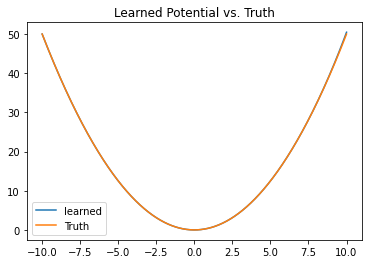

In [30]:
# print('Chebyshev Coefficients of the True Potential:', cvec, sep='\n')
# print('', 'Chebyshev Coefficients of the Learned Potential:', restrub, sep='\n')

print('Objective of the Learned Coefficients:', cobjfn(restrub), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(gradcobjfn(restrub)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(restrub)))[0], sep='\n')

# print('', 'Gradient of the Learned Coefficients:', gradcobjfn(restrub), sep='\n')

# print('', 'L2 Error of the Initialized Chebyshev Coefficients:', nl.norm(cvec - cfftrub), sep='\n')
# print('', 'L2 Error of the Learned Chebyshev Coefficients:', nl.norm(cvec - restrub), sep='\n')
# print('', 'L-infinity Error of the Initialized Chebyshev Coefficients:', np.max(np.abs(cvec - cfftrub)), sep='\n')
# print('', 'L-infinity Error of the Learned Chebyshev Coefficients:', np.max(np.abs(cvec - restrub)), sep='\n')

# plot learned vs true
# plt.plot(xvec, ctoxmat @ cfftrub, label='initial')
plt.plot(xvec, ctoxmat @ restrub, label='learned')
plt.plot(xvec, vxvec, label='Truth')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---

In [31]:
seed = 1234  # set to None for random initialization
# cffform = np.random.default_rng(seed).uniform(low=-0.5, high=0.5, size=cvec.shape)
cffform = np.random.default_rng(seed).uniform(low=-5.0, high=5.0, size=cvec.shape)

In [32]:
resform = spo.minimize(cobjfn, cffform, jac=gradcobjfn, tol=1e-15, options={'maxiter': 200, 'disp': True, 'gtol': 1e-14}).x

         Current function value: 130.725292
         Iterations: 187
         Function evaluations: 277
         Gradient evaluations: 265


Objective of the Learned Coefficients:
130.72529249734964
Vec L2 Norm of Gradient of the Learned Coefficients:
2.9917468844801473e-06
Continuous L2 Error of Potential using Quadrature Method:
1290.1495790626855


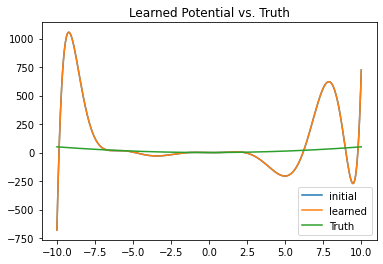

In [33]:
# print('Chebyshev Coefficients of the True Potential:', cvec, sep='\n')
# print('', 'Chebyshev Coefficients of the Learned Potential:', resform, sep='\n')

print('Objective of the Learned Coefficients:', cobjfn(resform), sep='\n')
print('Vec L2 Norm of Gradient of the Learned Coefficients:', nl.norm(gradcobjfn(resform)), sep='\n')

print('Continuous L2 Error of Potential using Quadrature Method:', np.sqrt(si.quad(sqrerrorfn, -L, L, args=(resform)))[0], sep='\n')

# print('', 'Gradient of the Learned Coefficients:', gradcobjfn(resform), sep='\n')

# print('', 'L2 Error of the Initialized Chebyshev Coefficients:', nl.norm(cvec - cffform), sep='\n')
# print('', 'L2 Error of the Learned Chebyshev Coefficients:', nl.norm(cvec - resform), sep='\n')
# print('', 'L-infinity Error of the Initialized Chebyshev Coefficients:', np.max(np.abs(cvec - cffform)), sep='\n')
# print('', 'L-infinity Error of the Learned Chebyshev Coefficients:', np.max(np.abs(cvec - resform)), sep='\n')

# plot learned vs true
plt.plot(xvec, ctoxmat @ resform, label='initial')
plt.plot(xvec, ctoxmat @ resform, label='learned')
plt.plot(xvec, vxvec, label='Truth')
# plt.xlim((-5, 5))
# plt.ylim((0, 10))
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()

---

In [46]:
def adjhelper(cffs):
    # construct the vmat from Chebyshev coefficients
    # function which returns the chebyshev approximation
    # given a set of coefficients
    def vcaprx(x):
        # don't forget that the chebyshev representation's
        # interval is x \in [-1, 1]
        return sps.eval_chebyt(np.expand_dims(cnvec, 0), x / L) @ cffs

    cvrow = []
    for thisn in range(2 * nF + 1):
        def intgrnd(x):
            return vcaprx(x) * np.exp(-1j * np.pi * thisn * x / L) / (2 * L)
        def rintgrnd(x):
            return jnp.real(intgrnd(x))
        def iintgrnd(x):
            return jnp.imag(intgrnd(x))
        cvrow.append(si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0])

    # make the python list cvrow a jax object
    cvrow = jnp.stack(cvrow)

    # make toeplitz matrix by hand, so it's JAX grad/jacobian
    # compliant
    flattoepvec = jnp.concatenate([jnp.flipud(cvrow.conj()), cvrow[1:]])
    # make potential matrix vmat from the Chebyshev coefficients
    vmat = flattoepvec[toepindxmat]

    # construct the Hamiltonian matrix in the
    # Fourier representation
    hmat = kmat + vmat

    # eigendecomposition of the Hamiltonian matrix
    spc, stts = jnpl.eigh(hmat)

    # compute the propagator matrix using the
    # result of the eigendecomposition
    propamat = stts @ np.diag(np.exp(-1j * spc * dt)) @ stts.conj().T
    propHmat = stts @ np.diag(np.exp(1j * spc * dt)) @ stts.conj().T

    # propagate the system starting from ainit
    # using propamat, i.e., solve the forward problem
    amat = [ainit]
    for i in range(ntsteps):
        amat.append(propamat @ amat[i])

    # make python list of Fourier basis wave functions
    # a jax object
    amat = jnp.stack(amat)

    # propagate the "lambda" vector of coefficients backward
    # in time, i.e., solve the adjoint problem
    lmat = [amat[ntsteps,:] - amat[ntsteps,:]]

    itr = 0 # forward evaluation of lmat
    for i in range(ntsteps - 1, -1, -1):
        lmat.append(amat[i,:] - Famat[i,:] + propHmat @ lmat[itr] )
        itr += 1

    lmat = jnp.flipud(jnp.stack(lmat))

    offdiagmask = jnp.ones((ntoepelm, ntoepelm)) - jnp.eye(ntoepelm)
    expspec = jnp.exp(-1j * dt * spc)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(spc, spc)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(ntoepelm)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)
    myeye = jnp.eye(ntoepelm)
    ws = jnp.hstack([jnp.fliplr(myeye), myeye[:,1:]]).T
    ctrmats = ws[toepindxmat]
    derivamats = jnp.einsum('ij,jkm,kl->ilm', stts.conj().T, ctrmats, stts) * jnp.expand_dims(mask, 2)
    alldmatreal = -1j * dt * jnp.einsum('ij,jkm,kl->mil', stts, derivamats, stts.conj().T)

    ws = 1.0j * jnp.hstack([-jnp.fliplr(myeye), myeye[:, 1:]])
    ws = ws[1:, :]
    ws = ws.T
    ctrmats = ws[toepindxmat]
    derivamats = jnp.einsum('ij,jkm,kl->ilm', stts.conj().T, ctrmats, stts) * jnp.expand_dims(mask, 2)
    alldmatimag = -1j*dt*jnp.einsum('ij,jkm,kl->mil', stts, derivamats, stts.conj().T)

    alldmat = jnp.vstack([alldmatreal, alldmatimag])

    return lmat, alldmat, amat

def cgradfn(cffs):
    lmat, alldmat, amat = adjhelper(cffs)
    # compute all entries of the gradient at once
    gradients = jnp.einsum('ij,ajk,ik->a', jnp.conj(lmat[1:, :]), alldmat, amat[:-1, :]).real
    return gradients